# Patch sampling from WSI images

Using selected cases for exploratory stage.

In [19]:
import csv
import h5py
import numpy as np
from openslide import open_slide  
from openslide.deepzoom import DeepZoomGenerator
from shapely.geometry import Polygon, Point
from scipy.misc import imresize
from PIL import Image
import matplotlib.pyplot as plt

import json
import time
from datetime import timedelta

In [7]:
# Helper timing functions.
def start_timer():
	return time.time()

def end_timer(start_time):
	end_time = time.time()
	print("Time usage: " + str(timedelta(seconds=int(round(end_time - start_time)))))


def show_labeled_patches(images, clss):
    fig = plt.figure(figsize=(20, 10))
    data = images[:50]
    labels = clss[:50]

    for i, image in enumerate(data):
        plt.subplot(5, 10, i+1)
        plt.imshow(image)
        plt.title(str(labels[i]))
        plt.axis("off")

    plt.show()

Set directories for svs files and json annotations.

In [18]:
img_dir = "/Users/ysbecca/ysbecca-projects/bcsp-expert/data/wsi_samples/"
test_db_dir = "/Users/ysbecca/ysbecca-projects/bcsp-expert/data/temp_db/"
json_dir = img_dir

image_id = 101527
single_img = img_dir + "101527.svs"


patch_size = 128
level = 13
pixel_overlap = 0
downsample_factor = 8

new_patch_dim = int(patch_size / downsample_factor)

annotation_downsample = 10 # Downsampling annotated regions for quickly labeling patches
label_map = {"EP": 0,
             "SM": 1,
             "U": -1} # Unknown

In [9]:
def patch_to_tile_size(patch_size, overlap):
    return patch_size - overlap*2

In [10]:
tile_size = patch_to_tile_size(patch_size, pixel_overlap)

slide = open_slide(single_img) # .svs
tiles = DeepZoomGenerator(slide, tile_size=tile_size, overlap=pixel_overlap, limit_bounds=True)

In [11]:
tiles.level_tiles[level]

(59, 39)

In [12]:
def fetch_regions(image_id):
    path = json_dir + str(image_id)
    
    regions, region_labels = [], []
    try:
        with open(path + "_EP.json") as f_:
            data = json.load(f_)
        # Downsample regions before saving
        # print("Found ", len(data), "regions in EP file.")
        
        data_ = np.array([np.array(xi) for xi in data])
        for d in data_:
            region_labels.append("EP")
            regions.append(np.multiply(np.array(d), 1.0/annotation_downsample))
            
    except(FileNotFoundError, IOError):
        print("No EP file available for " + str(image_id))
    try:
        with open(path + "_SM.json") as f_:
            data = json.load(f_)
        # Downsample regions before saving
        # print("Found ", len(data), "regions in SM file.")        
        
        data_ = np.array([np.array(xi) for xi in data])
        for d in data_:
            region_labels.append("SM")
            regions.append(np.multiply(np.array(d), 1.0/annotation_downsample))
            
            
    except(FileNotFoundError, IOError):
        print("No SM file available for " + str(image_id))

    return regions, region_labels

def generate_label(polys, region_labels, point):
    # regions = array of vertices (all_coords)
    # point [x, y]
    
    # see if point is in any of regions provided
    for i in range(len(region_labels)): 
        if polys[i].contains(Point(point[0], point[1])):
            return label_map[region_labels[i]]
    else:
        return -1 # not in any of the regions - unknown label

In [13]:
json_dir + str(image_id) + "_EP.json"

'/Users/ysbecca/ysbecca-projects/bcsp-expert/data/wsi_samples/101527_EP.json'

In [14]:
start_time = start_timer()

x_tiles, y_tiles = tiles.level_tiles[level]

print("x tiles:", x_tiles, "and y tiles:", y_tiles)

x, y = 0, 0
count = 0
patches, coords, labels = [], [], []

regions, region_labels = fetch_regions(image_id)
polys = [Polygon(r) for r in regions]

while y < y_tiles:
    while x < x_tiles:
        new_tile = np.array(tiles.get_tile(level, (x, y)), dtype=np.uint8)
        new_tile = imresize(new_tile, (new_patch_dim, new_patch_dim))
        
        # OpenSlide calculates overlap in such a way that sometimes depending on the dimensions, edge 
        # patches are smaller than the others. We will ignore such patches.
        if np.shape(new_tile) == (new_patch_dim, new_patch_dim, 3):
            patches.append(new_tile)
            coords.append(np.array([x, y]))
            count += 1

            # Calculate the patch label based on centre point.
            point = tiles.get_tile_coordinates(level, (x, y))[0]
 
            point_ = (point[0]/annotation_downsample, point[1]/annotation_downsample)
            labels.append(generate_label(polys, region_labels, point_))
            
        x += 1
    y += 1
    x = 0

end_timer(start_time)


x tiles: 59 and y tiles: 39
Time usage: 0:01:24


In [17]:
print(np.shape(patches))
print(np.shape(coords))
print(np.shape(labels))

(2301, 16, 16, 3)
(2301, 2)
(2301,)


Save patches and meta in hdf5/csv files.

In [24]:
def store_hdf5(patches, dir_path, coords, labels, csv_name):
    ''' Saves patches into hdf5 files, and meta into csv files '''

    print("Writing csv to:", csv_name + '.csv')

    # First write meta.
    with open(dir_path + csv_name + '.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for i in range(len(labels)):
             # Last entry is is_pseudo_label, set to 1 when labeling
            row = [labels[i], coords[i][0], coords[i][1], 0]
            writer.writerow(row)

    print("Wrote csv.")
    file = h5py.File(dir_path + csv_name + '.h5','w')
    print("Created file", file)
    dataset = file.create_dataset('t', np.shape(patches), h5py.h5t.STD_I32BE, data=patches, compression="gzip", compression_opts=9)

    print("===================")
    print("Meta data saved in", csv_name + ".csv")
    print("Dataset dataspace is " + str(dataset.shape))
    print("Dataset numpy datatype is " + str(dataset.dtype))
    print("Dataset name is " + str(dataset.name))
    print("Dataset was created in the file " + str(dataset.file))
    print("===================")
    file.close()

In [25]:
# Store images by image_id + seg + patch_size + level + downsample_factor
csv_name = str(image_id) + "_seg_P" + str(patch_size) + "_L" + str(level) + "_D" + str(downsample_factor)
store_hdf5(patches, test_db_dir, coords, labels, csv_name)

Writing csv to: 101527_seg_P128_L13_D8.csv
Wrote csv.
Created file <HDF5 file "101527_seg_P128_L13_D8.h5" (mode r+)>
Meta data saved in 101527_seg_P128_L13_D8.csv
Dataset dataspace is (2301, 16, 16, 3)
Dataset numpy datatype is >i4
Dataset name is /t
Dataset was created in the file <HDF5 file "101527_seg_P128_L13_D8.h5" (mode r+)>


In [26]:
# start = 1157
# end = 1257
# show_labeled_patches([Image.fromarray(p, 'RGB') for p in patches[start:end]], labels[start:end])

In [27]:
# np.where(np.array(labels) > 0)

In [32]:
def read_patches_and_meta(image_id):
    ''' Reads num_patches patches and meta into numpy arrays. '''

    csv_name = "101527_seg_P128_L13_D8.csv"
    hdf_name = "101527_seg_P128_L13_D8.h5"
    
    patches_, coords_, labels_ = [], [], []
    
    # First read patch meta data
    with open(test_db_dir + csv_name, newline='') as metafile:
        reader = csv.reader(metafile, delimiter=' ', quotechar='|')
        for i, row in enumerate(reader):
            labels_.append(int(row[0]))
            coords_.append([int(row[1]), int(row[2])])

    # Now load the images from H5 file
    file = h5py.File(test_db_dir + hdf_name,'r+')
    dataset = file['/' + 't']
    new_patches = np.array(dataset).astype('uint8')
    for i, patch in enumerate(new_patches):
        patches_.append(patch)

    file.close()
    return np.array(patches_), np.array(labels_), np.array(coords_)


In [33]:
patches, labels, coords = read_patches_and_meta(image_id)

In [36]:
print(np.shape(patches))
print(np.shape(coords))
print(np.shape(labels))

(2301, 16, 16, 3)
(2301, 2)
(2301,)


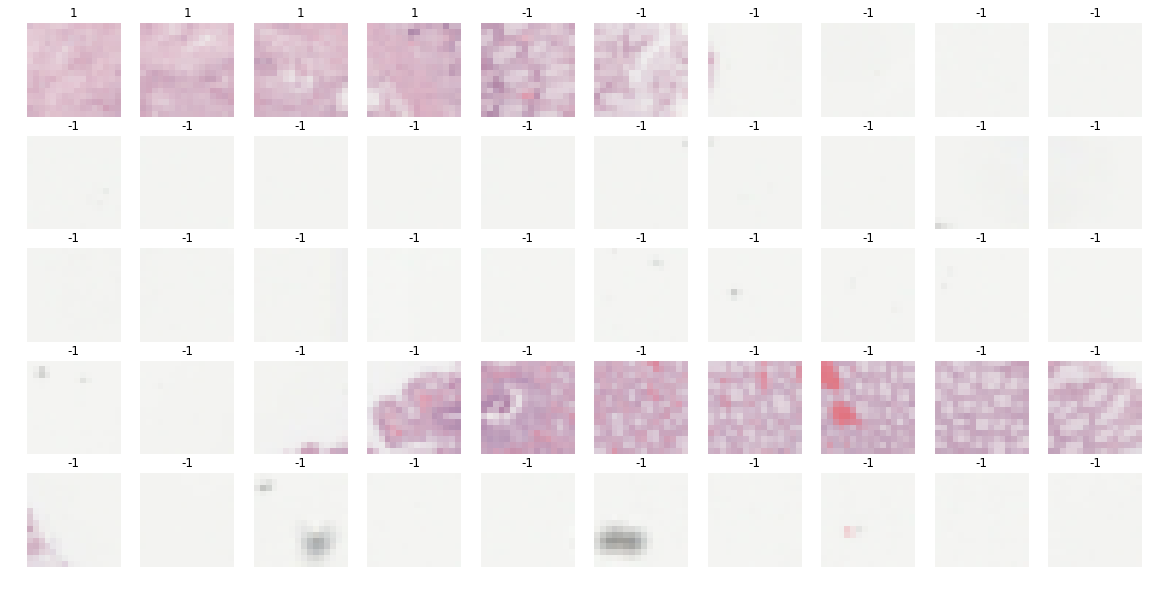

In [37]:
start = 1157
end = 1257
show_labeled_patches([Image.fromarray(p, 'RGB') for p in patches[start:end]], labels[start:end])